# Stroke Prognosis: Prueba de los Modelos

<p>
Curso de Minería de Datos <br>
Autor: Cristian Pavez Hormazábal
</p>

In [1]:
# Importación de librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import random

import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import yellowbrick as yb
from yellowbrick.classifier import ConfusionMatrix


In [2]:
# Importación de datos
dataset = pd.read_csv("all-data.csv")

# Formateo de los datos
dataset.drop("id", axis=1, inplace=True)
dataset['gender'] = dataset['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
dataset['ever_married'] = dataset['ever_married'].map({'Yes': 1, 'No': 0})
dataset['work_type'] = dataset['work_type'].map({'Private': 4, 'Self-employed': 2, 'Govt_job': 3, 'children': 1, 'Never_worked': 0})
dataset['Residence_type'] = dataset['Residence_type'].map({'Rural': 0, 'Urban': 1})
dataset['smoking_status'] = dataset['smoking_status'].map({'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3})

# Eliminar filas con valores perdidos
dataset_no_bmi = dataset.drop("bmi", axis=1)
dataset = dataset.dropna()

# Dividir el dataset en personas con y sin stroke
stroke_data = dataset[dataset['stroke'] == 1]
no_stroke_data = dataset[dataset['stroke'] == 0]

# Sobre-representar los datos de stroke
stroke_data_overrepresented = pd.concat([stroke_data] * 10, ignore_index=True)

# Combinar los datasets
balanced_dataset = pd.concat([stroke_data_overrepresented, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Segundo Balanceo
# Dividir el dataset en personas con y sin stroke
stroke_data = dataset_no_bmi[dataset_no_bmi['stroke'] == 1]
no_stroke_data = dataset_no_bmi[dataset_no_bmi['stroke'] == 0]

# Sobre-representar los datos de stroke
stroke_data_overrepresented = pd.concat([stroke_data] * 10, ignore_index=True)

# Combinar los datasets
balanced_dataset2 = pd.concat([stroke_data_overrepresented, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
balanced_dataset2 = balanced_dataset2.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance
print('Dataset original:', dataset['stroke'].value_counts())
print('Dataset sin IMC:', dataset_no_bmi['stroke'].value_counts())
print('Dataset original balanceado:', balanced_dataset['stroke'].value_counts())
print('Dataset sin IMC balanceado:', balanced_dataset2['stroke'].value_counts())

Dataset original: stroke
0    4700
1     209
Name: count, dtype: int64
Dataset sin IMC: stroke
0    4861
1     249
Name: count, dtype: int64
Dataset original balanceado: stroke
0    4700
1    2090
Name: count, dtype: int64
Dataset sin IMC balanceado: stroke
0    4861
1    2490
Name: count, dtype: int64


In [3]:
# Configuración de los sets de entrenamiento y prueba para cada set
def set_training_and_test(dataset):

    training_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

    x = dataset[training_columns]
    y = dataset['stroke']

    x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state = random.randint(0,100), test_size=0.2, shuffle=True)

    return x_train, x_test, y_train, y_test

def set_training_and_test2(dataset):

    training_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status']

    x = dataset[training_columns]
    y = dataset['stroke']

    x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state = random.randint(0,100), test_size=0.2, shuffle=True)

    return x_train, x_test, y_train, y_test

In [4]:
# Función para probar modelos
def prueba_modelos(dataset, model_name, model, dataset_name):
    vp = []
    vn = []
    fp = []
    fn = []
    accuracy = []
    precision = []
    recall = []
    for i in range(1, 10):
        naive_bayes = model
        x_train, x_test, y_train, y_test = set_training_and_test(dataset)
        naive_bayes.fit(x_train, y_train)
        previsoes = naive_bayes.predict(x_test)

        # Evaluación del modelo
        vp.append(np.sum((previsoes == 1) & (y_test == 1)))
        vn.append(np.sum((previsoes == 0) & (y_test == 0)))
        fp.append(np.sum((previsoes == 1) & (y_test == 0)))
        fn.append(np.sum((previsoes == 0) & (y_test == 1)))
        accuracy.append((vp[-1] + vn[-1]) / len(y_test))
        precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
        recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

    # Imprimir CM
    vp_promedio = np.mean(vp)
    vn_promedio = np.mean(vn)
    fp_promedio = np.mean(fp)
    fn_promedio = np.mean(fn)

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {vp_promedio}\tFN promedio: {vn_promedio}")
    print(f"\tFP promedio: {fp_promedio}\tVN promedio: {fn_promedio}")

    print(f"\tAccuracy promedio: {np.mean(accuracy)}")
    print(f"\tPrecision promedio: {np.mean(precision)}")
    print(f"\tRecall promedio: {np.mean(recall)}")

    # Boxplot para VP, VN, FP, FN
    data = {
        'VP': vp,
        'VN': vn,
        'FP': fp,
        'FN': fn
    }
    df = pd.DataFrame(data)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title(f'Boxplot de VP, VN, FP, FN para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()

    # Boxplot para Accuracy, Precision, Recall
    data_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }
    df_metrics = pd.DataFrame(data_metrics)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_metrics)
    plt.ylim(0, 1)
    plt.title(f'Boxplot de Accuracy, Precision, Recall para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()

def prueba_modelos2(dataset, model_name, model, dataset_name):
    vp = []
    vn = []
    fp = []
    fn = []
    accuracy = []
    precision = []
    recall = []
    for i in range(1, 10):
        naive_bayes = model
        x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
        naive_bayes.fit(x_train, y_train)
        previsoes = naive_bayes.predict(x_test)

        # Evaluación del modelo
        vp.append(np.sum((previsoes == 1) & (y_test == 1)))
        vn.append(np.sum((previsoes == 0) & (y_test == 0)))
        fp.append(np.sum((previsoes == 1) & (y_test == 0)))
        fn.append(np.sum((previsoes == 0) & (y_test == 1)))
        accuracy.append((vp[-1] + vn[-1]) / len(y_test))
        precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
        recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

    # Imprimir CM
    vp_promedio = np.mean(vp)
    vn_promedio = np.mean(vn)
    fp_promedio = np.mean(fp)
    fn_promedio = np.mean(fn)

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {vp_promedio}\tFN promedio: {vn_promedio}")
    print(f"\tFP promedio: {fp_promedio}\tVN promedio: {fn_promedio}")

    print(f"\tAccuracy promedio: {np.mean(accuracy)}")
    print(f"\tPrecision promedio: {np.mean(precision)}")
    print(f"\tRecall promedio: {np.mean(recall)}")

    # Boxplot para VP, VN, FP, FN
    data = {
        'VP': vp,
        'VN': vn,
        'FP': fp,
        'FN': fn
    }
    df = pd.DataFrame(data)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title(f'Boxplot de VP, VN, FP, FN para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()

    # Boxplot para Accuracy, Precision, Recall
    data_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }
    df_metrics = pd.DataFrame(data_metrics)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_metrics)
    plt.ylim(0, 1)
    plt.title(f'Boxplot de Accuracy, Precision, Recall para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()




	VP promedio: 16.444444444444443	FN promedio: 839.3333333333334
	FP promedio: 100.77777777777777	VN promedio: 25.444444444444443
	Accuracy promedio: 0.8714641321565966
	Precision promedio: 0.14035826767996765
	Recall promedio: 0.39321402804965905


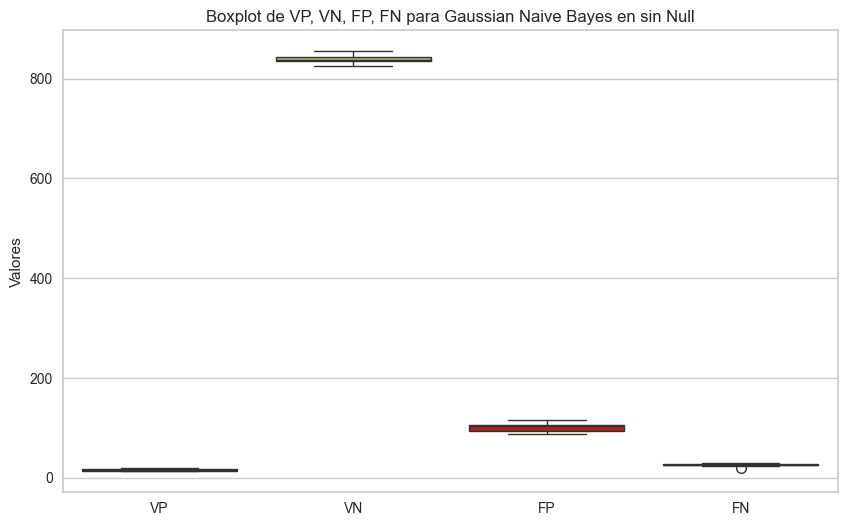

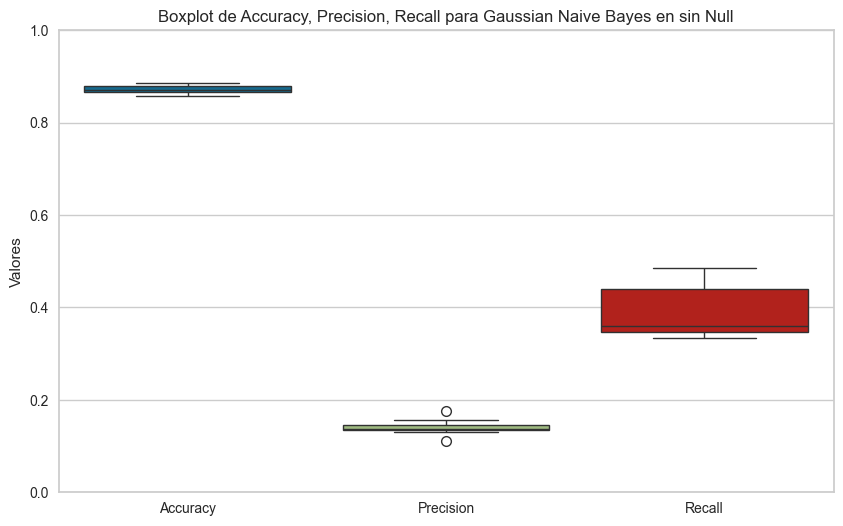

	VP promedio: 249.22222222222223	FN promedio: 787.5555555555555
	FP promedio: 152.44444444444446	VN promedio: 168.77777777777777
	Accuracy promedio: 0.763459335624284
	Precision promedio: 0.6205564965265093
	Recall promedio: 0.5960069353607496


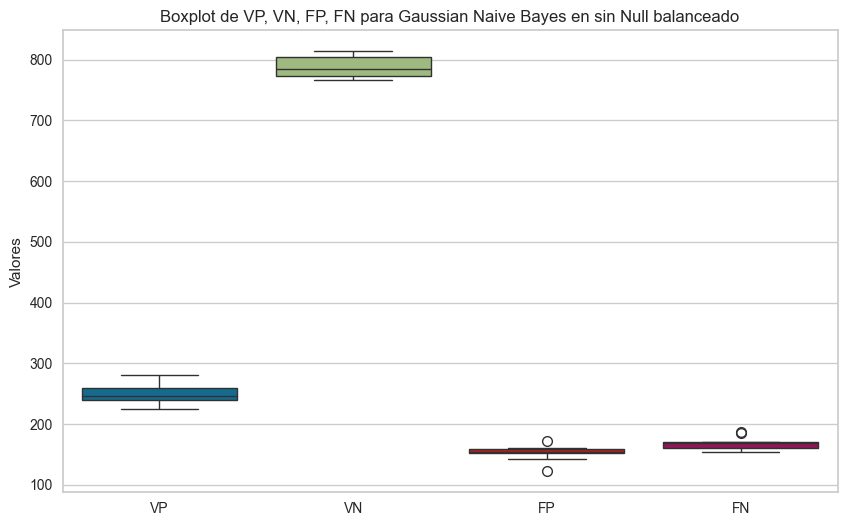

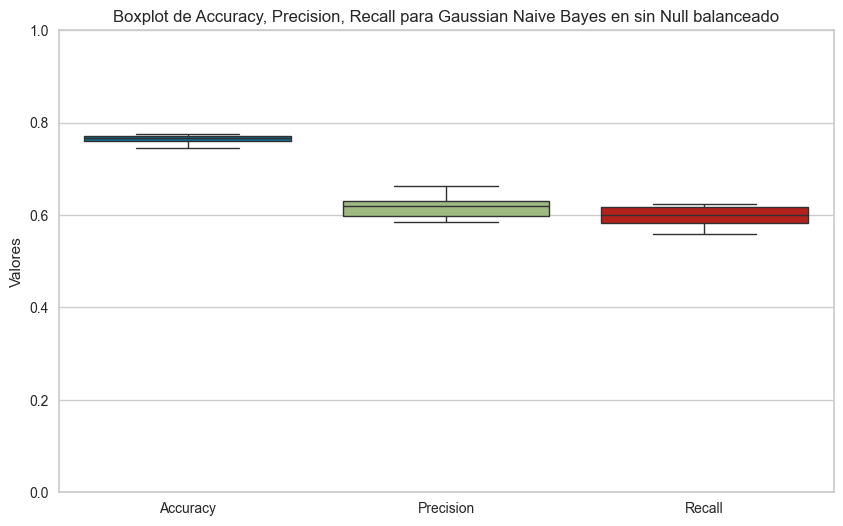

	VP promedio: 18.11111111111111	FN promedio: 862.5555555555555
	FP promedio: 109.22222222222223	VN promedio: 32.111111111111114
	Accuracy promedio: 0.8617090671885193
	Precision promedio: 0.1424178912867878
	Recall promedio: 0.3602993646864706


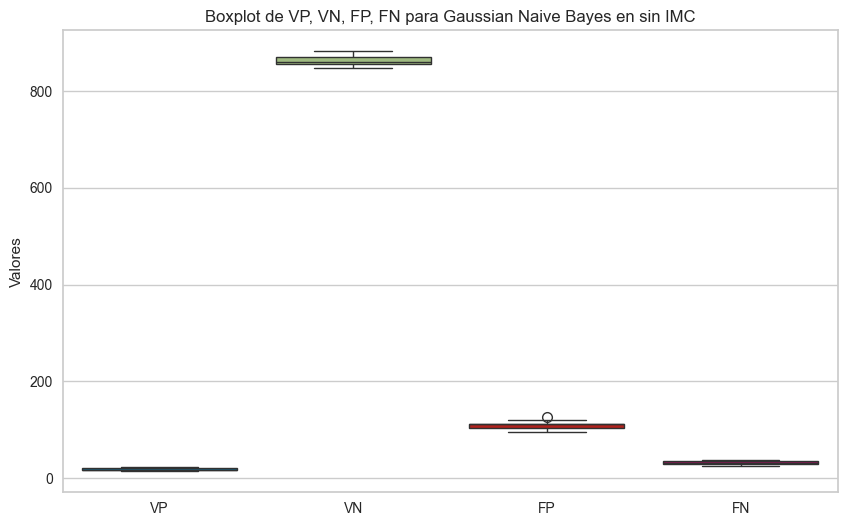

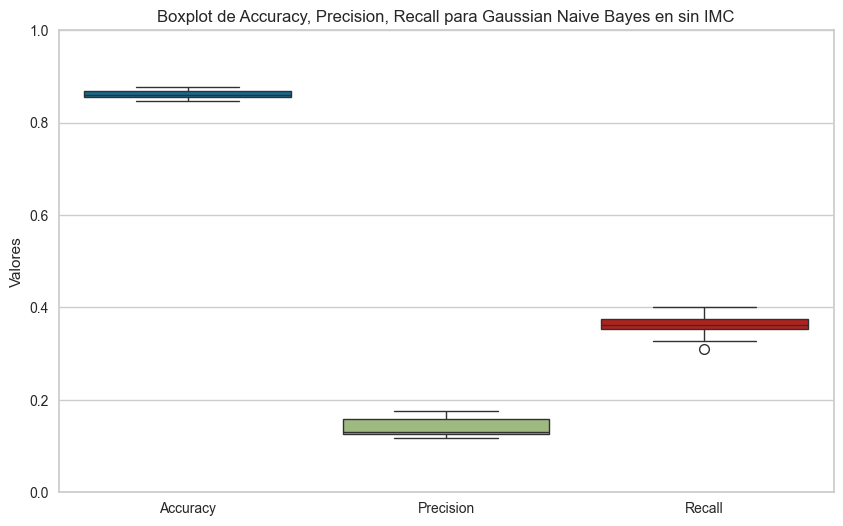

	VP promedio: 297.44444444444446	FN promedio: 797.0
	FP promedio: 176.0	VN promedio: 200.55555555555554
	Accuracy promedio: 0.7440138983306896
	Precision promedio: 0.6283234590159962
	Recall promedio: 0.5971844930491067


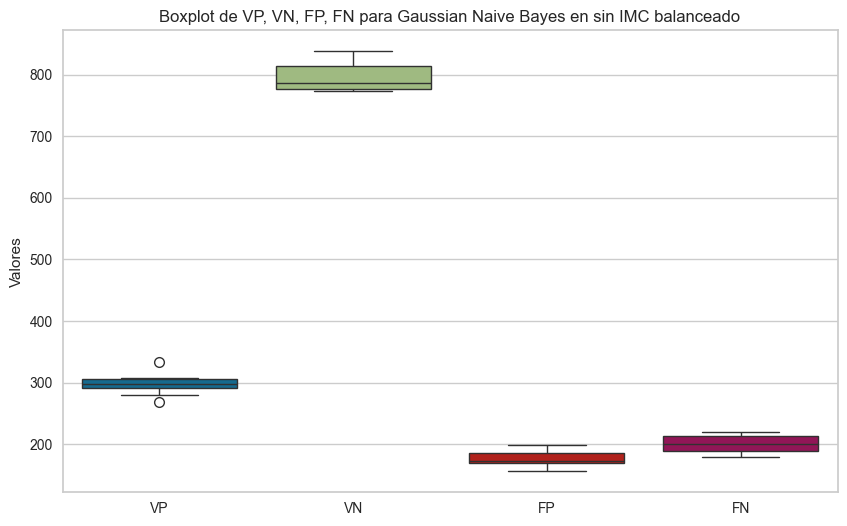

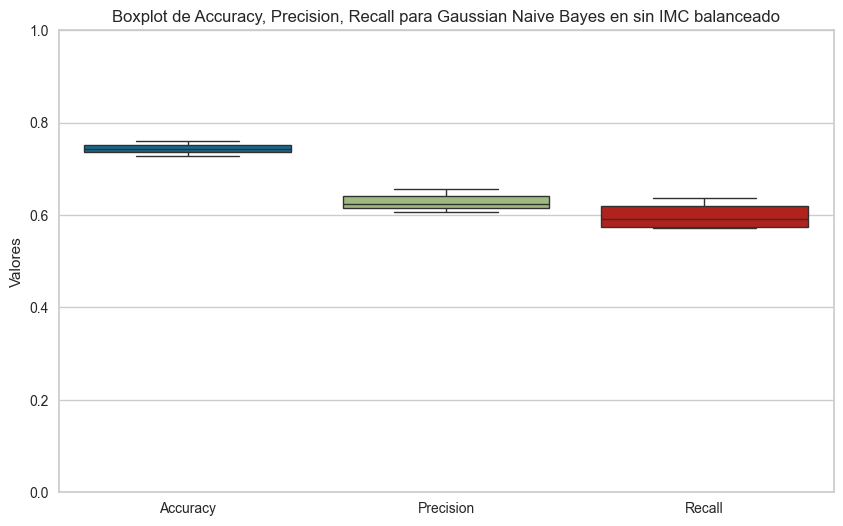

In [5]:
# Gaussian Naive Bayes
prueba_modelos(dataset, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin Null")
prueba_modelos(balanced_dataset, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin Null balanceado")
prueba_modelos2(dataset_no_bmi, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin IMC")
prueba_modelos2(balanced_dataset2, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin IMC balanceado")



	VP promedio: 1.0	FN promedio: 935.0
	FP promedio: 6.888888888888889	VN promedio: 39.111111111111114
	Accuracy promedio: 0.9531568228105907
	Precision promedio: 0.12708032708032707
	Recall promedio: 0.025539419865661002


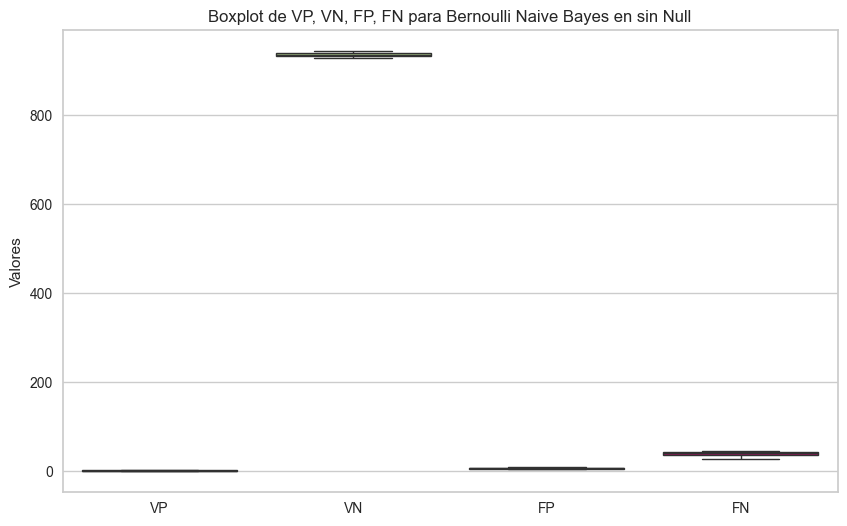

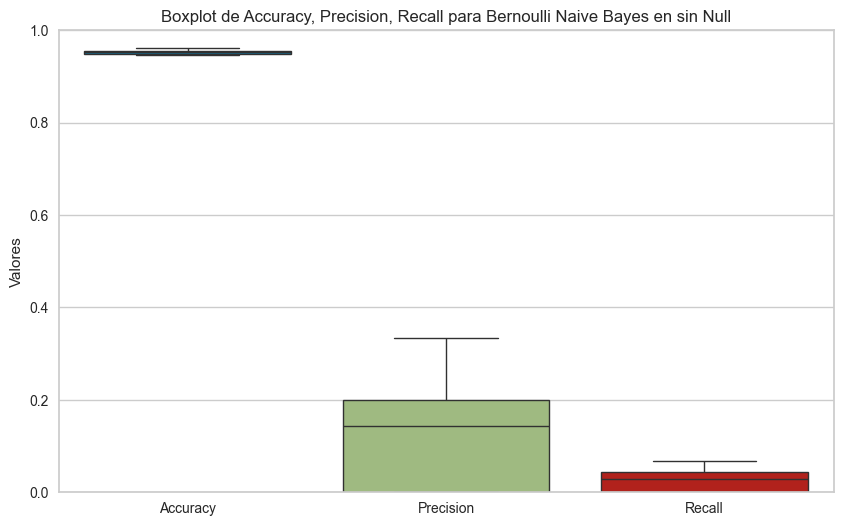

	VP promedio: 155.0	FN promedio: 853.8888888888889
	FP promedio: 82.44444444444444	VN promedio: 266.6666666666667
	Accuracy promedio: 0.7429225985927017
	Precision promedio: 0.6518199966051206
	Recall promedio: 0.3668174444084718


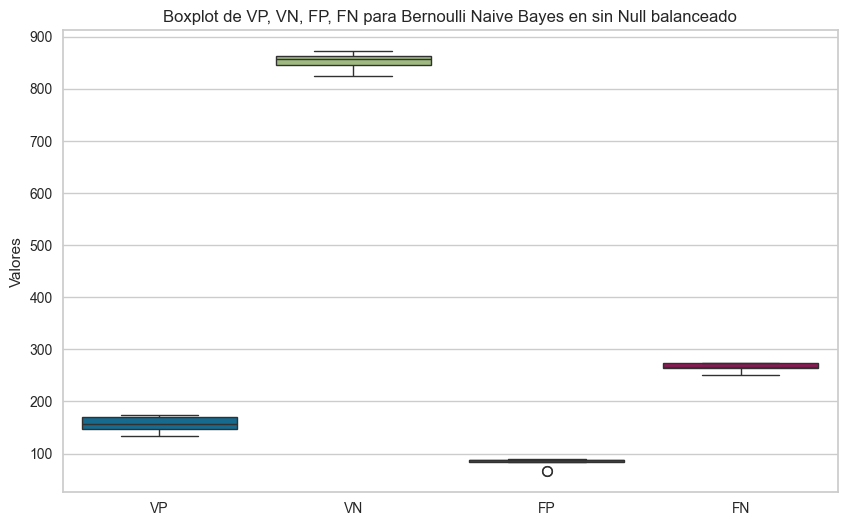

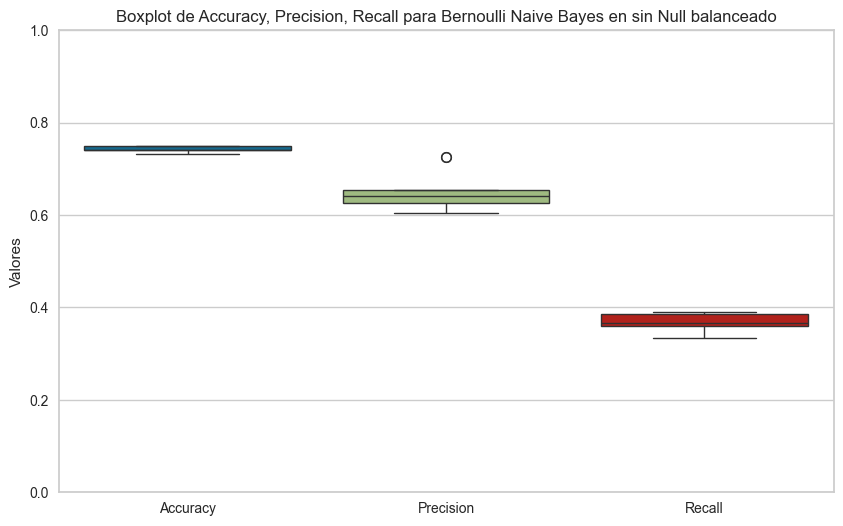

	VP promedio: 0.5555555555555556	FN promedio: 970.6666666666666
	FP promedio: 1.8888888888888888	VN promedio: 48.888888888888886
	Accuracy promedio: 0.9503152859317243
	Precision promedio: 0.17407407407407408
	Recall promedio: 0.010899223754520912


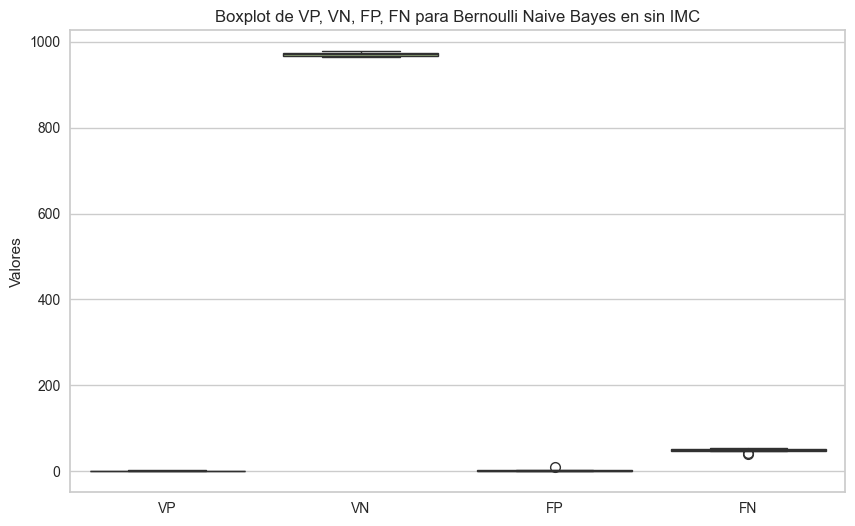

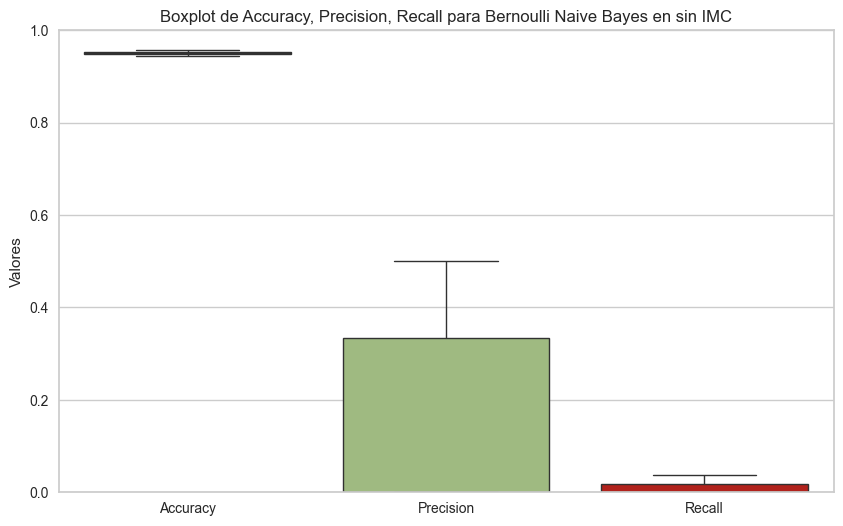

	VP promedio: 182.44444444444446	FN promedio: 864.6666666666666
	FP promedio: 112.22222222222223	VN promedio: 311.6666666666667
	Accuracy promedio: 0.7118362414079613
	Precision promedio: 0.6194638604325655
	Recall promedio: 0.36954572008805364


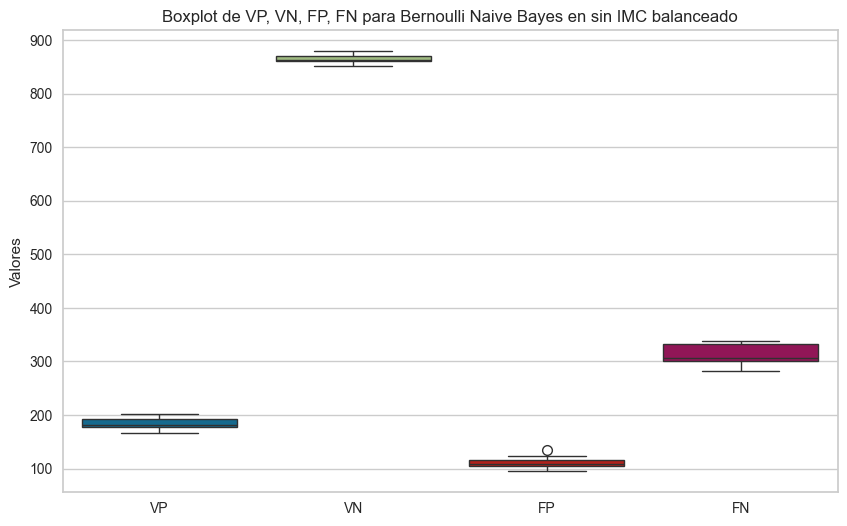

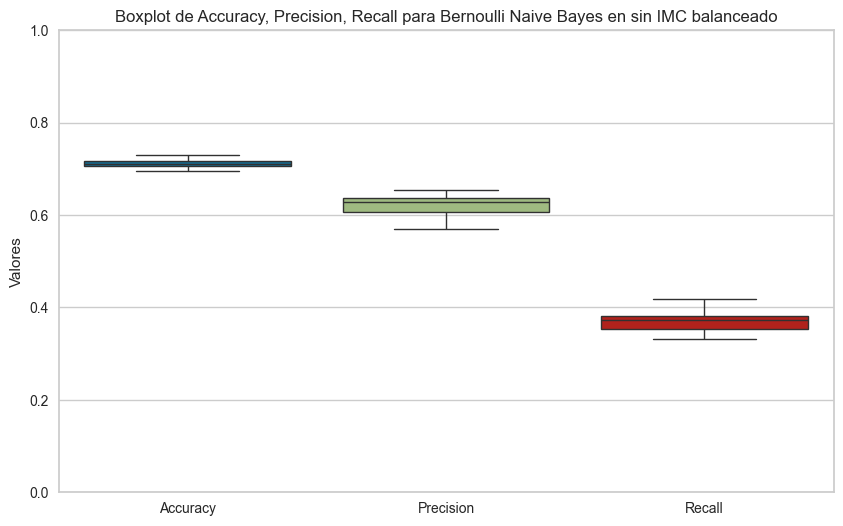

In [6]:
# Bernoulli Naive Bayes
prueba_modelos(dataset, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin Null")
prueba_modelos(balanced_dataset, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin Null balanceado")
prueba_modelos2(dataset_no_bmi, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin IMC")
prueba_modelos2(balanced_dataset2, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin IMC balanceado")



	VP promedio: 5.888888888888889	FN promedio: 896.4444444444445
	FP promedio: 43.55555555555556	VN promedio: 36.111111111111114
	Accuracy promedio: 0.9188730482009504
	Precision promedio: 0.11779632388818771
	Recall promedio: 0.14297464685061584


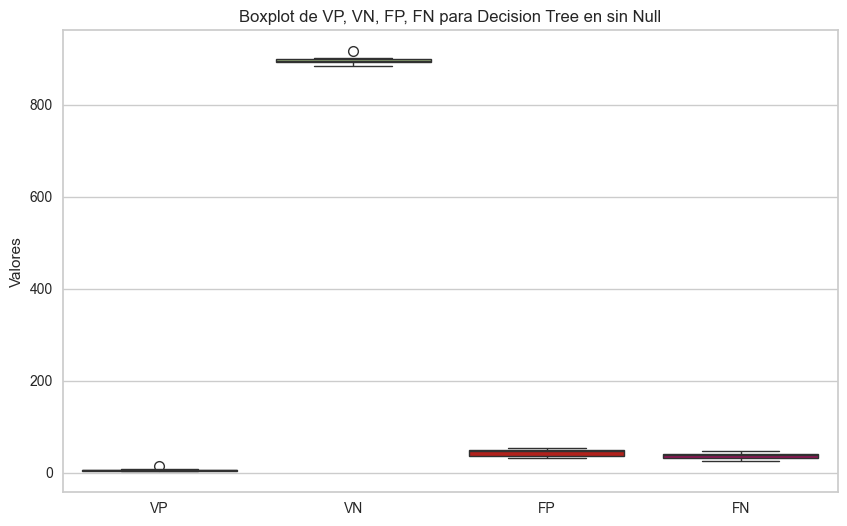

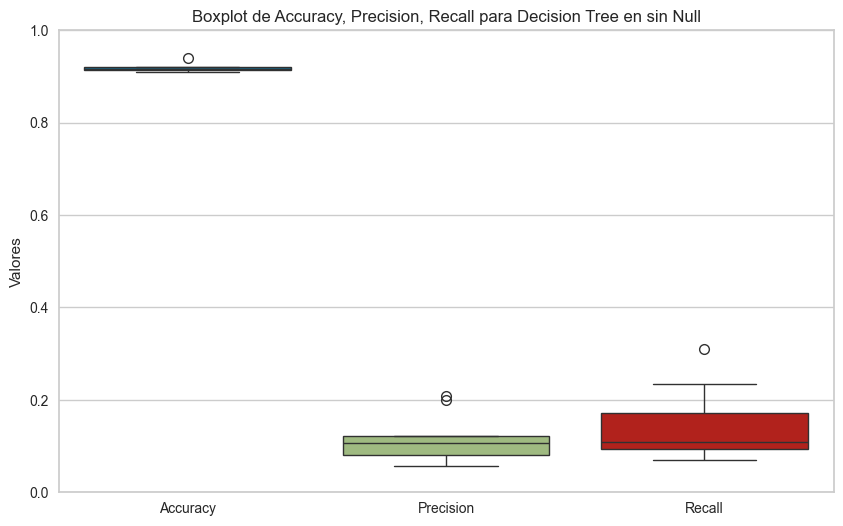

	VP promedio: 423.3333333333333	FN promedio: 889.6666666666666
	FP promedio: 45.0	VN promedio: 0.0
	Accuracy promedio: 0.966863033873343
	Precision promedio: 0.9038873757707228
	Recall promedio: 1.0


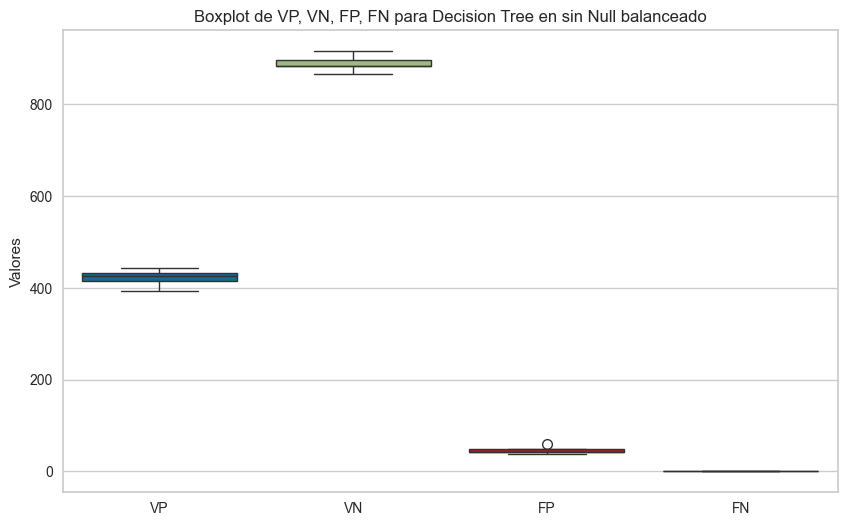

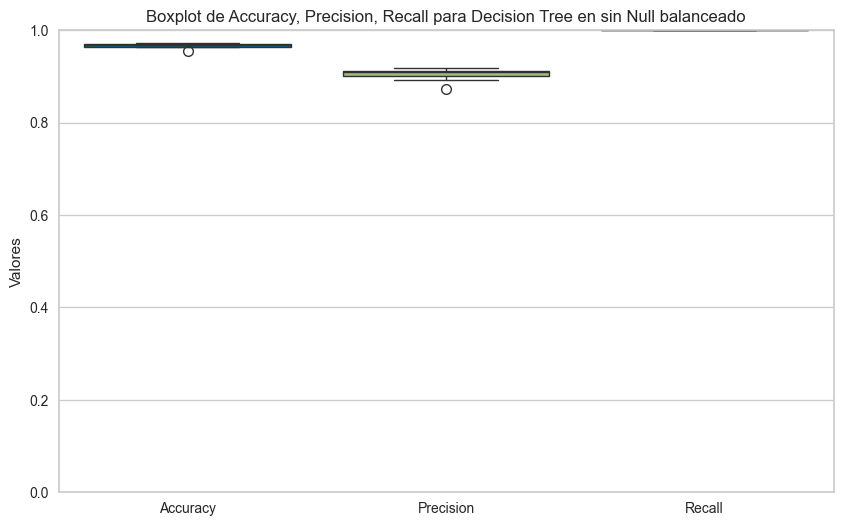

	VP promedio: 8.222222222222221	FN promedio: 923.6666666666666
	FP promedio: 47.666666666666664	VN promedio: 42.44444444444444
	Accuracy promedio: 0.911828658404001
	Precision promedio: 0.14668651121513093
	Recall promedio: 0.16077164216239445


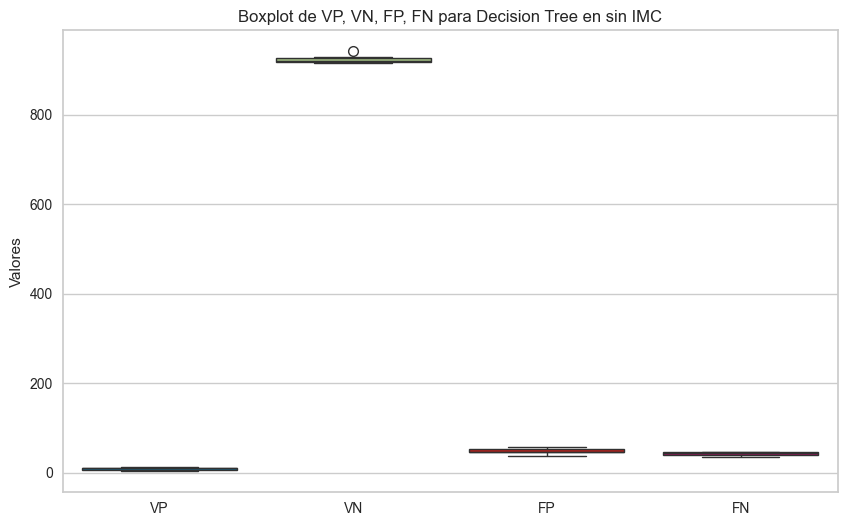

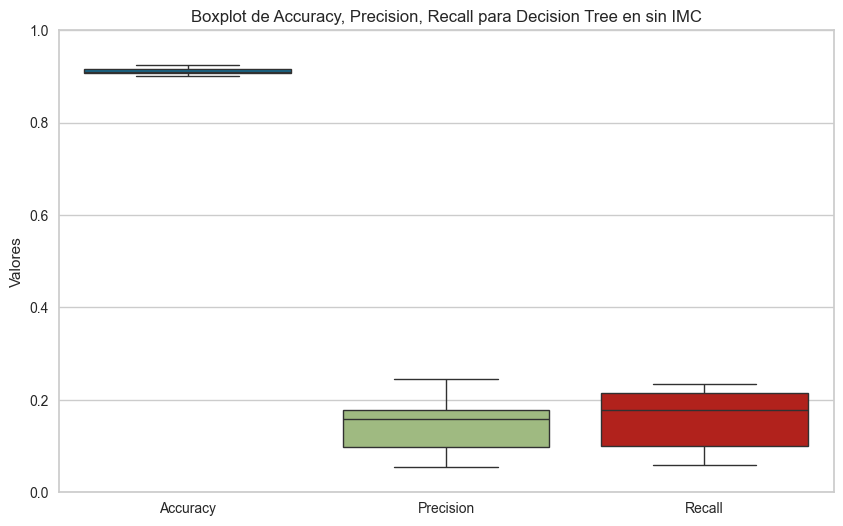

	VP promedio: 491.1111111111111	FN promedio: 925.6666666666666
	FP promedio: 54.22222222222222	VN promedio: 0.0
	Accuracy promedio: 0.9631392099101141
	Precision promedio: 0.9005706652860437
	Recall promedio: 1.0


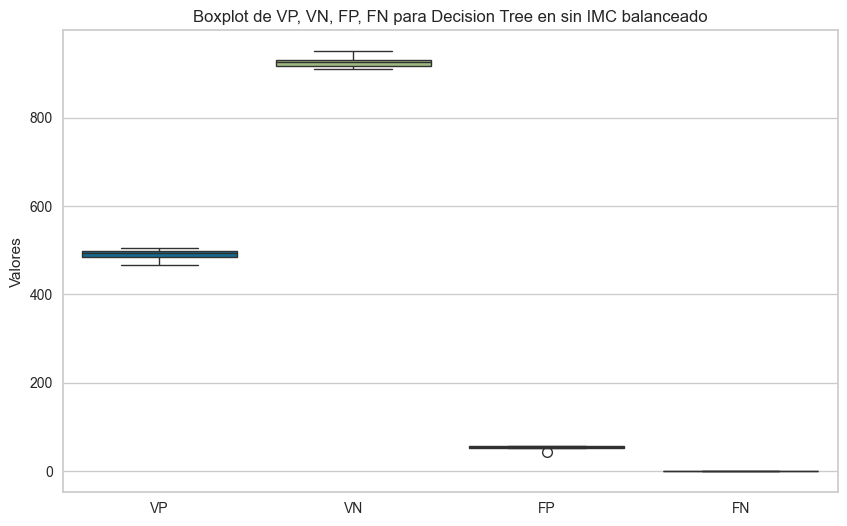

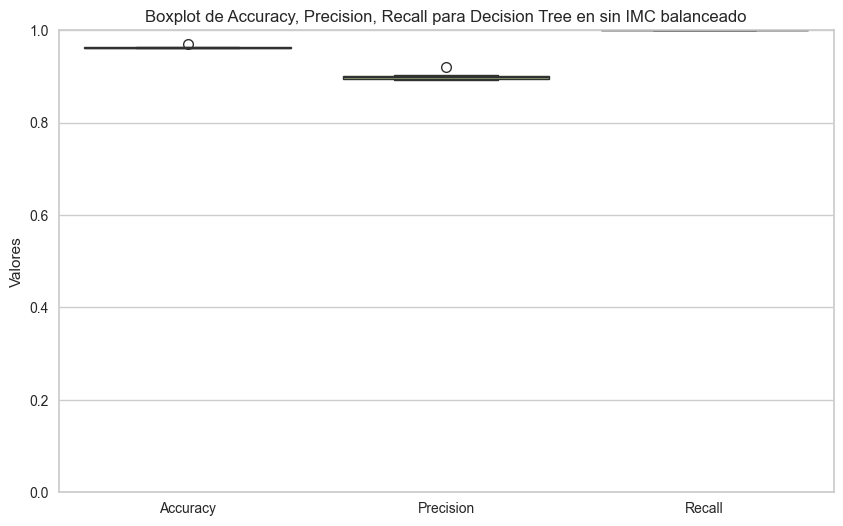

In [7]:
# Decision Tree
prueba_modelos(dataset, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin Null")
prueba_modelos(balanced_dataset, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin Null balanceado")
prueba_modelos2(dataset_no_bmi, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin IMC")
prueba_modelos2(balanced_dataset2, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin IMC balanceado")


In [8]:
# Funcion para probar modelos KNN
def prueba_modelos_KNN(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []

    for k in range(1, 31):
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
            x_train, x_test, y_train, y_test = set_training_and_test(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))
    
    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {np.mean(vp_proms)}\tFN promedio: {np.mean(fn_proms)}")
    print(f"\tFP promedio: {np.mean(fp_proms)}\tVN promedio: {np.mean(vn_proms)}")

    print(f"\tAccuracy promedio: {np.mean(acc_proms)}")
    print(f"\tPrecision promedio: {np.mean(prec_proms)}")
    print(f"\tRecall promedio: {np.mean(rec_proms)}")

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), vp_proms, 'o-', label='VP')
    plt.plot(range(1, 31), vn_proms, 'o-', label='VN')
    plt.plot(range(1, 31), fp_proms, 'o-', label='FP')
    plt.plot(range(1, 31), fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), acc_proms, 'o-', label='Accuracy')
    plt.plot(range(1, 31), prec_proms, 'o-', label='Precision')
    plt.plot(range(1, 31), rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

def prueba_modelos_KNN2(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []

    for k in range(1, 31):
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
            x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {np.mean(vp_proms)}\tVN promedio: {np.mean(fn_proms)}")
    print(f"\tFP promedio: {np.mean(fp_proms)}\tFN promedio: {np.mean(vn_proms)}")

    print(f"\tAccuracy promedio: {np.mean(acc_proms)}")
    print(f"\tPrecision promedio: {np.mean(prec_proms)}")
    print(f"\tRecall promedio: {np.mean(rec_proms)}")
    
    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), vp_proms, 'o-', label='VP')
    plt.plot(range(1, 31), vn_proms, 'o-', label='VN')
    plt.plot(range(1, 31), fp_proms, 'o-', label='FP')
    plt.plot(range(1, 31), fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), acc_proms, 'o-', label='Accuracy')
    plt.plot(range(1, 31), prec_proms, 'o-', label='Precision')
    plt.plot(range(1, 31), rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

	VP promedio: 0.33999999999999997	FN promedio: 40.69666666666667
	FP promedio: 2.4366666666666665	VN promedio: 938.5266666666666
	Accuracy promedio: 0.9560760353021043
	Precision promedio: 0.021166998593649854
	Recall promedio: 0.00799310862240913


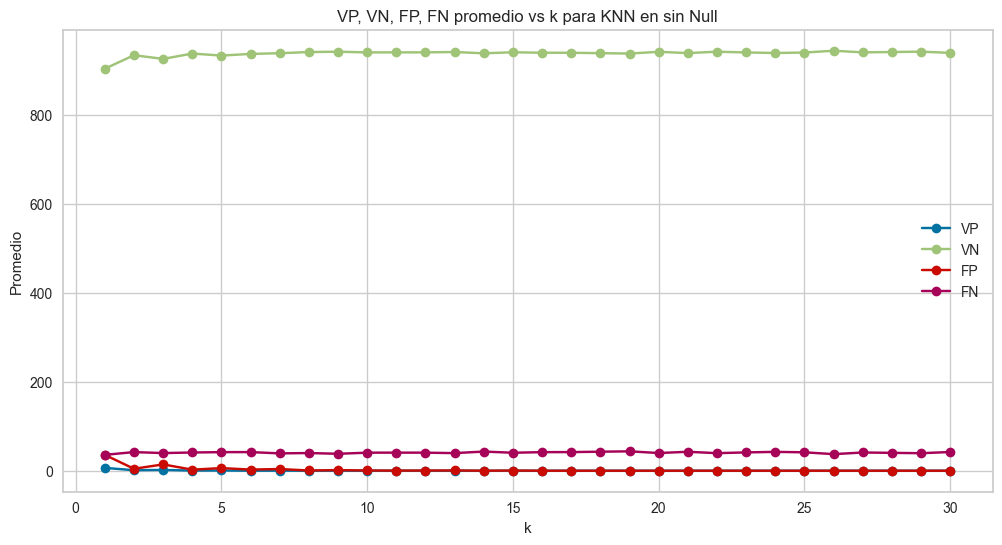

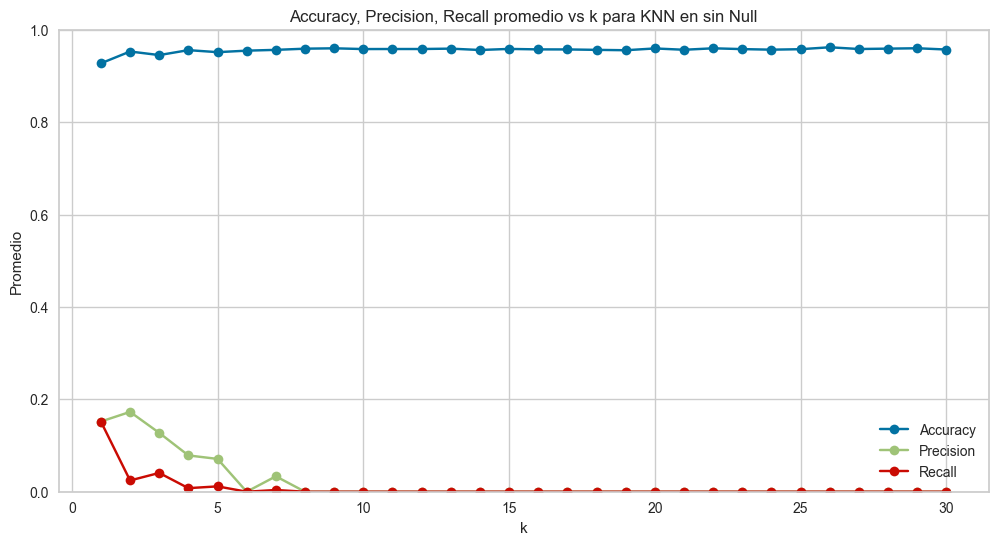

	VP promedio: 351.42	FN promedio: 69.01333333333334
	FP promedio: 141.70333333333335	VN promedio: 795.8633333333333
	Accuracy promedio: 0.8448330878743252
	Precision promedio: 0.711999395852347
	Recall promedio: 0.83588570376108


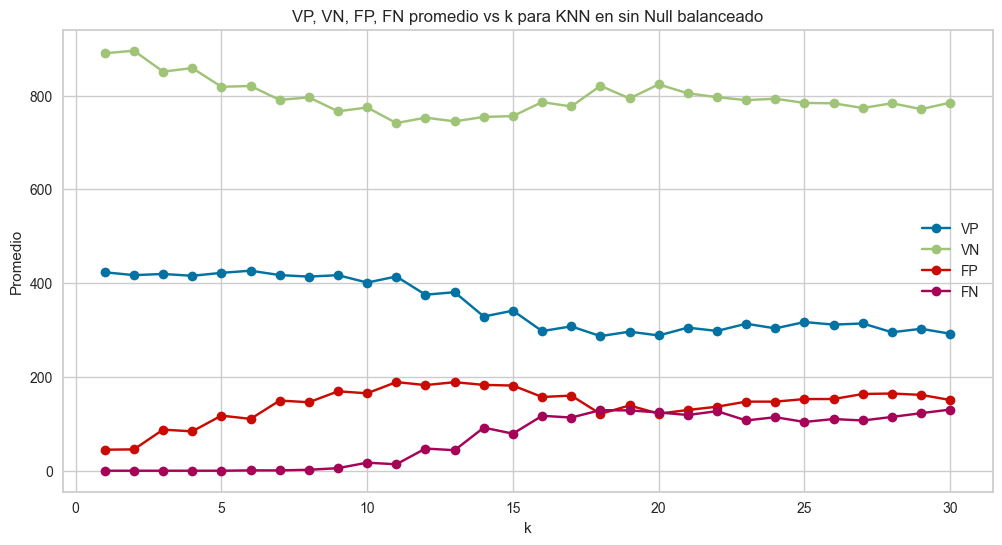

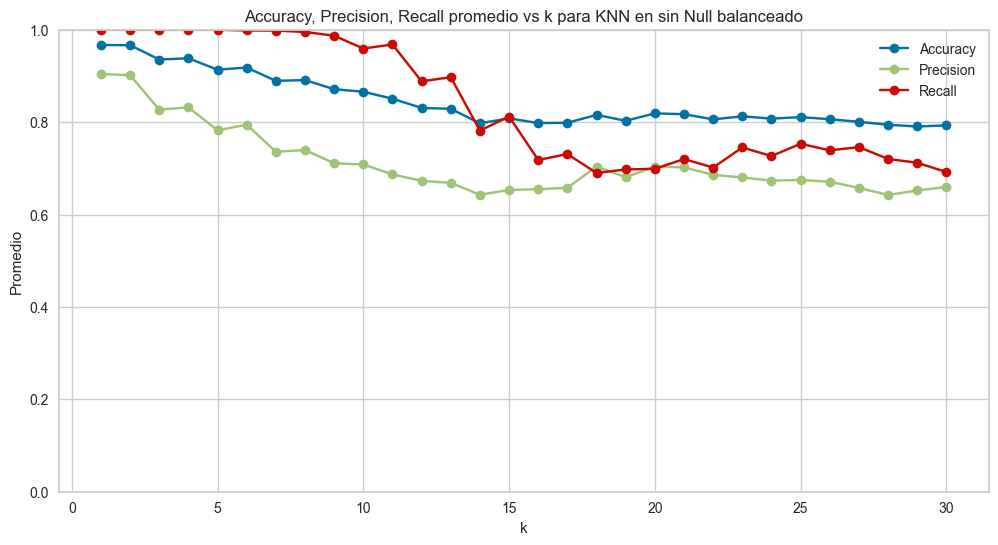

	VP promedio: 0.4	VN promedio: 50.14666666666666
	FP promedio: 2.6	FN promedio: 968.8533333333334
	Accuracy promedio: 0.9483887801696022
	Precision promedio: 0.03185662568712682
	Recall promedio: 0.007768711659686034


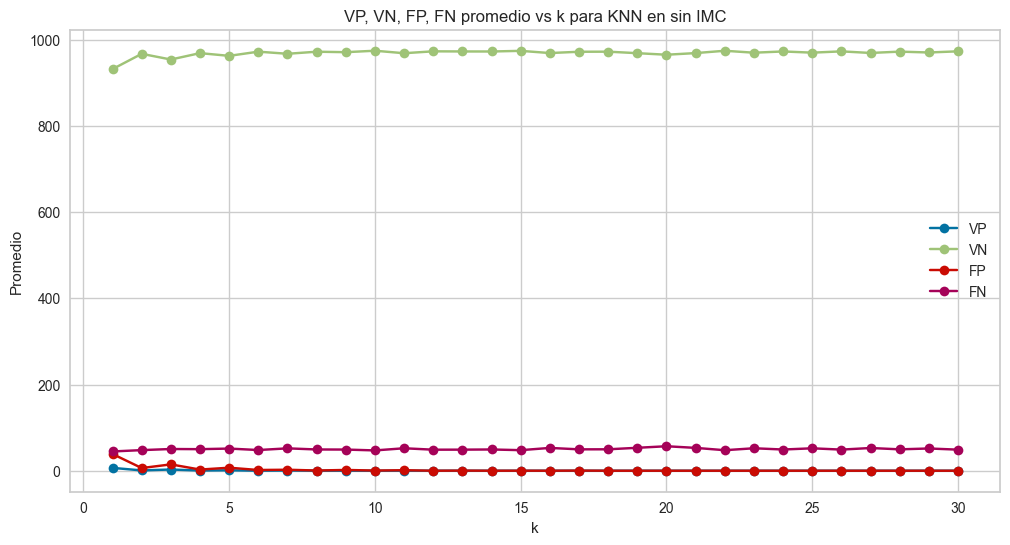

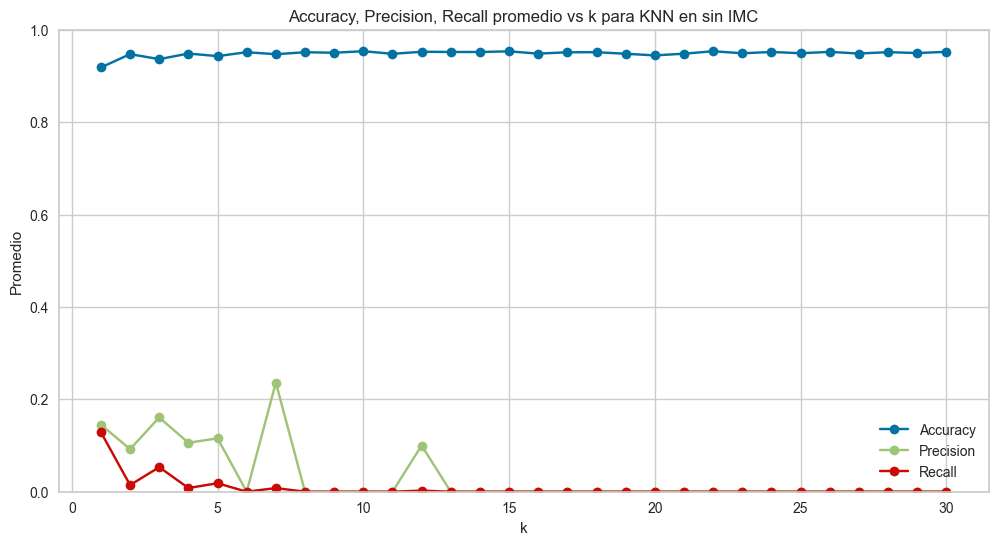

	VP promedio: 422.1433333333333	VN promedio: 72.70333333333333
	FP promedio: 161.72333333333333	FN promedio: 814.4300000000001
	Accuracy promedio: 0.8406344890097439
	Precision promedio: 0.7232548414717662
	Recall promedio: 0.8535515608541345


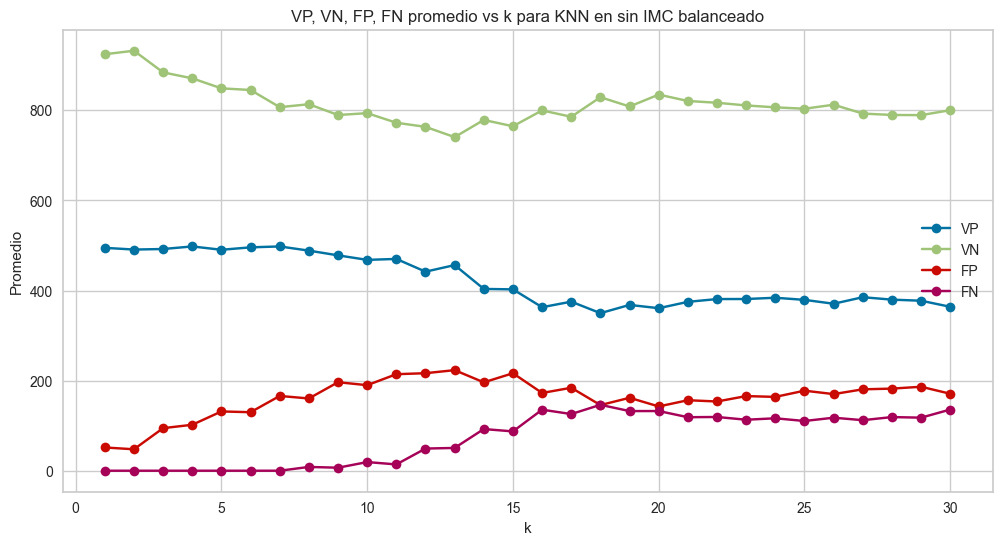

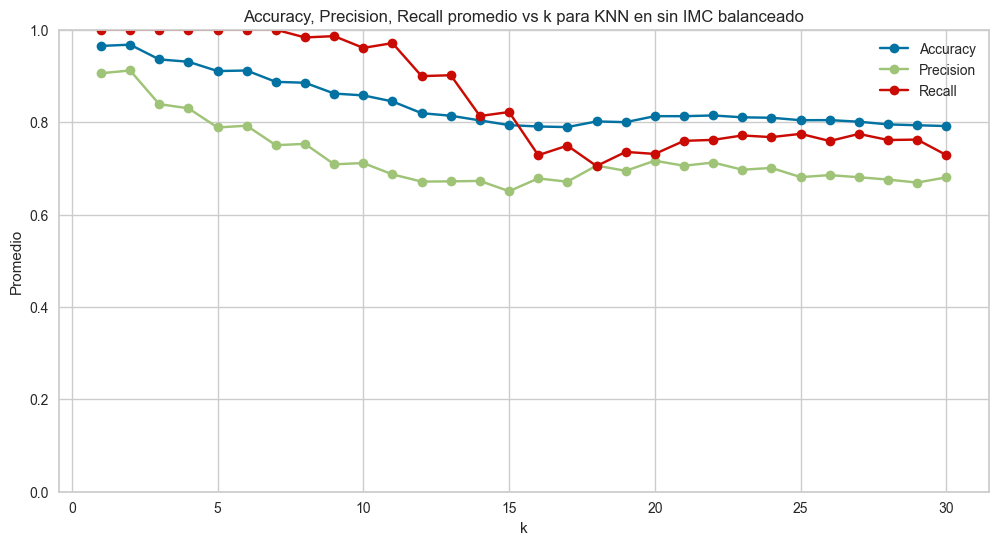

In [9]:
# KNN
prueba_modelos_KNN(dataset, "KNN", "sin Null")
prueba_modelos_KNN(balanced_dataset, "KNN", "sin Null balanceado")
prueba_modelos_KNN2(dataset_no_bmi, "KNN", "sin IMC")
prueba_modelos_KNN2(balanced_dataset2, "KNN", "sin IMC balanceado")


In [10]:
# Funcion para probar modelos Random Forest
def prueba_modelos_RF(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    pruebas = [10, 20, 50, 100, 200, 500]

    for k in pruebas:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = RandomForestClassifier(n_estimators=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {np.mean(vp_proms)}\tVN promedio: {np.mean(vn_proms)}")
    print(f"\tFP promedio: {np.mean(fp_proms)}\tFN promedio: {np.mean(fn_proms)}")

    print(f"\tAccuracy promedio: {np.mean(acc_proms)}")
    print(f"\tPrecision promedio: {np.mean(prec_proms)}")
    print(f"\tRecall promedio: {np.mean(rec_proms)}")

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, vp_proms, 'o-', label='VP')
    plt.plot(pruebas, vn_proms, 'o-', label='VN')
    plt.plot(pruebas, fp_proms, 'o-', label='FP')
    plt.plot(pruebas, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs cantidad de árboles para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, acc_proms, 'o-', label='Accuracy')
    plt.plot(pruebas, prec_proms, 'o-', label='Precision')
    plt.plot(pruebas, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs cantidad de árboles para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

def prueba_modelos_RF2(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    pruebas = [10, 20, 50, 100, 200, 500]

    for k in pruebas:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = RandomForestClassifier(n_estimators=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {np.mean(vp_proms)}\tVN promedio: {np.mean(vn_proms)}")
    print(f"\tFP promedio: {np.mean(fp_proms)}\tFN promedio: {np.mean(fn_proms)}")

    print(f"\tAccuracy promedio: {np.mean(acc_proms)}")
    print(f"\tPrecision promedio: {np.mean(prec_proms)}")
    print(f"\tRecall promedio: {np.mean(rec_proms)}")
    
    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, vp_proms, 'o-', label='VP')
    plt.plot(pruebas, vn_proms, 'o-', label='VN')
    plt.plot(pruebas, fp_proms, 'o-', label='FP')
    plt.plot(pruebas, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs cantidad de árboles para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, acc_proms, 'o-', label='Accuracy')
    plt.plot(pruebas, prec_proms, 'o-', label='Precision')
    plt.plot(pruebas, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs cantidad de árboles para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

	VP promedio: 0.46666666666666673	VN promedio: 938.7666666666665
	FP promedio: 1.7333333333333334	FN promedio: 41.03333333333333
	Accuracy promedio: 0.9564494229463679
	Precision promedio: 0.16515873015873014
	Recall promedio: 0.011813220666899105


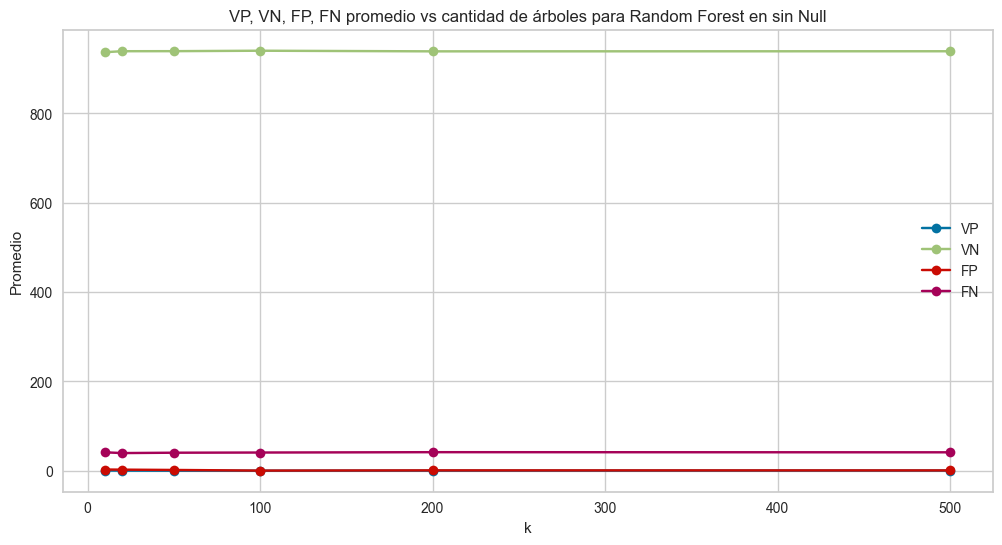

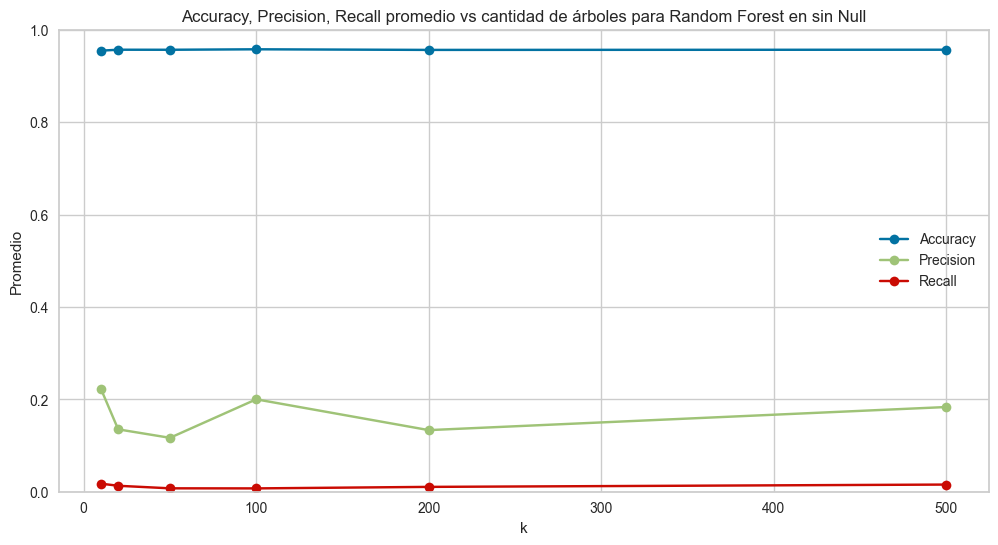

	VP promedio: 423.93333333333334	VN promedio: 920.9333333333333
	FP promedio: 13.133333333333333	FN promedio: 0.0
	Accuracy promedio: 0.9903289150711831
	Precision promedio: 0.9699376955880394
	Recall promedio: 1.0


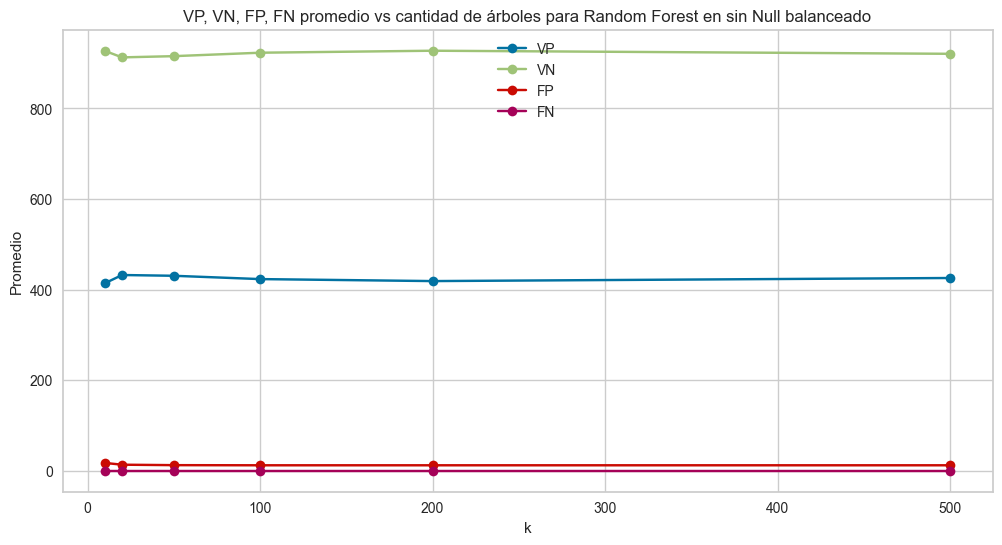

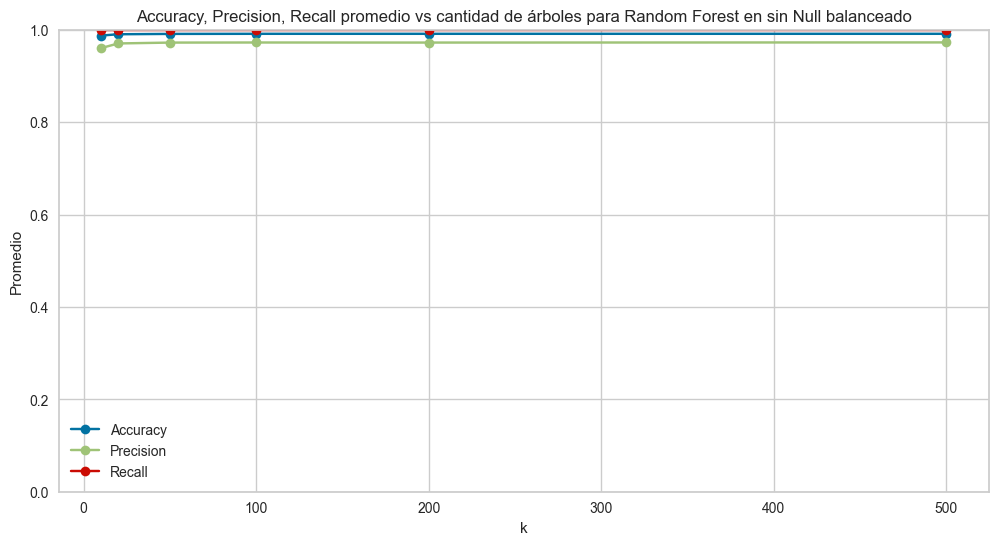

	VP promedio: 1.15	VN promedio: 967.9166666666669
	FP promedio: 4.033333333333333	FN promedio: 48.9
	Accuracy promedio: 0.9482061317677756
	Precision promedio: 0.21570406445406443
	Recall promedio: 0.02257340898514355


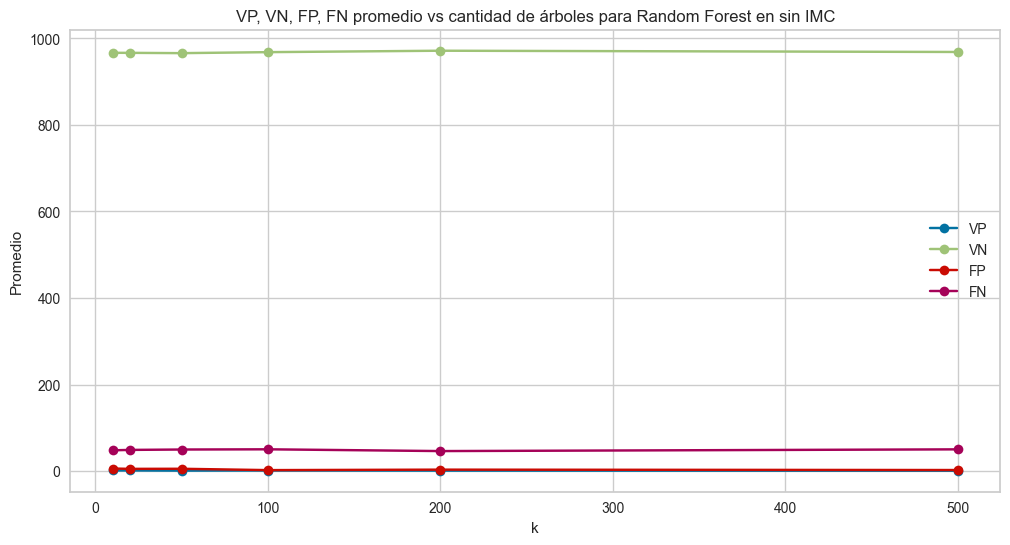

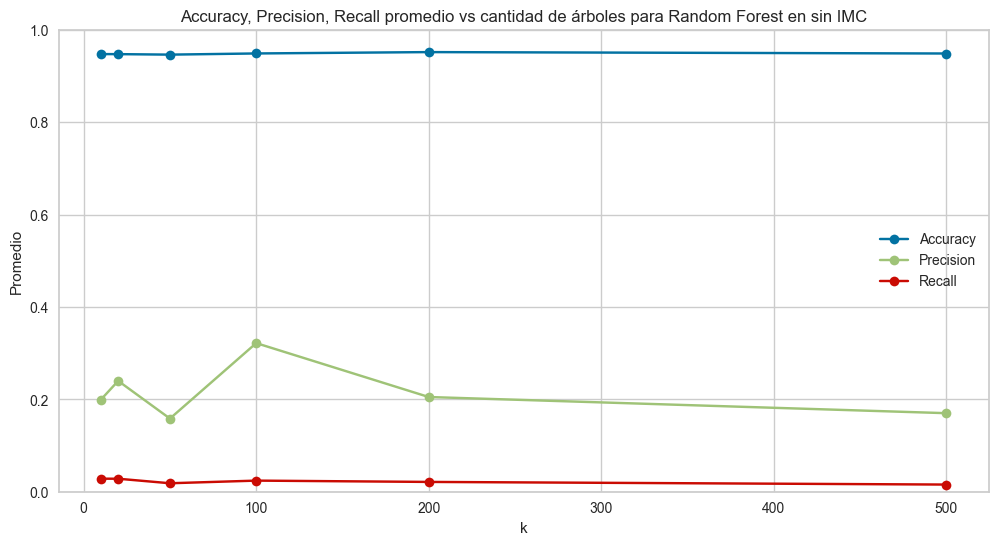

	VP promedio: 500.78333333333336	VN promedio: 948.2833333333333
	FP promedio: 21.933333333333334	FN promedio: 0.0
	Accuracy promedio: 0.9850895082710173
	Precision promedio: 0.9580226814939308
	Recall promedio: 1.0


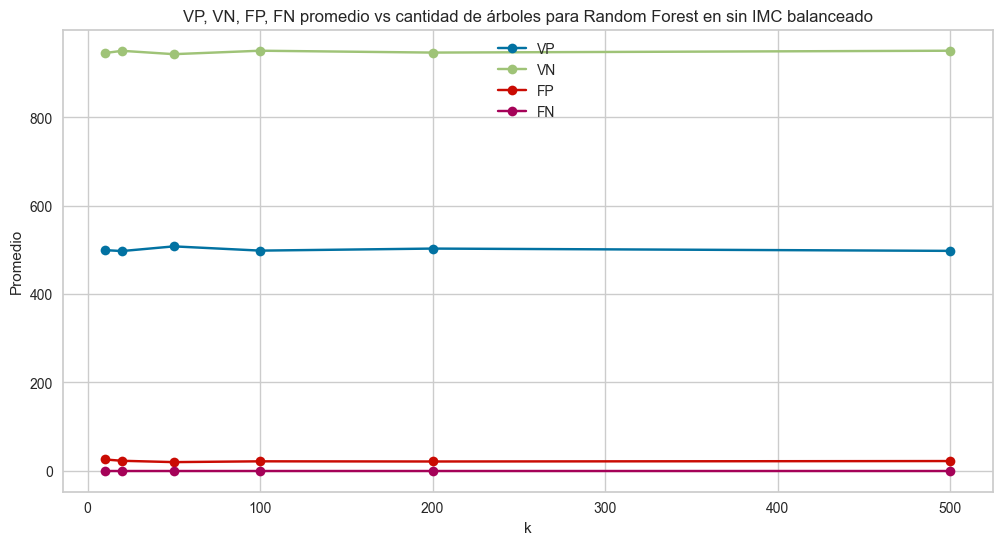

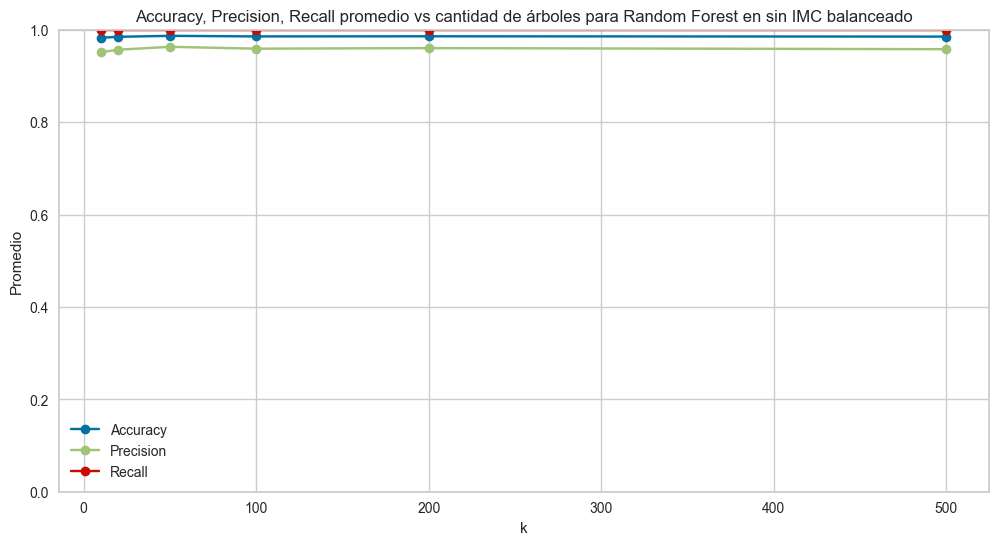

In [11]:
# Random Forest
prueba_modelos_RF(dataset, "Random Forest", "sin Null")
prueba_modelos_RF(balanced_dataset, "Random Forest", "sin Null balanceado")
prueba_modelos_RF2(dataset_no_bmi, "Random Forest", "sin IMC")
prueba_modelos_RF2(balanced_dataset2, "Random Forest", "sin IMC balanceado")

In [12]:
# Función para probar modelos SVM
def prueba_modelos_SVM(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    kernel = ["linear", "poly", "rbf", "sigmoid"]

    for k in kernel:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            svm = SVC(kernel=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test(dataset)
            svm.fit(x_train, y_train)
            previsoes = svm.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {vp_proms}\tVN promedio: {vn_proms}")
    print(f"\tFP promedio: {fp_proms}\tFN promedio: {fn_proms}")

    print(f"\tAccuracy promedio: {np.mean(acc_proms)}")
    print(f"\tPrecision promedio: {np.mean(prec_proms)}")
    print(f"\tRecall promedio: {np.mean(rec_proms)}")

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, vp_proms, 'o-', label='VP')
    plt.plot(kernel, vn_proms, 'o-', label='VN')
    plt.plot(kernel, fp_proms, 'o-', label='FP')
    plt.plot(kernel, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, acc_proms, 'o-', label='Accuracy')
    plt.plot(kernel, prec_proms, 'o-', label='Precision')
    plt.plot(kernel, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()


def prueba_modelos_SVM2(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    kernel = ["linear", "poly", "rbf", "sigmoid"]

    for k in kernel:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            svm = SVC(kernel=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
            svm.fit(x_train, y_train)
            previsoes = svm.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {vp_proms}\tVN promedio: {vn_proms}")
    print(f"\tFP promedio: {fp_proms}\tFN promedio: {fn_proms}")

    print(f"\tAccuracy promedio: {np.mean(acc_proms)}")
    print(f"\tPrecision promedio: {np.mean(prec_proms)}")
    print(f"\tRecall promedio: {np.mean(rec_proms)}")
    
    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, vp_proms, 'o-', label='VP')
    plt.plot(kernel, vn_proms, 'o-', label='VN')
    plt.plot(kernel, fp_proms, 'o-', label='FP')
    plt.plot(kernel, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, acc_proms, 'o-', label='Accuracy')
    plt.plot(kernel, prec_proms, 'o-', label='Precision')
    plt.plot(kernel, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

	VP promedio: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]	VN promedio: [np.float64(940.9), np.float64(939.4), np.float64(939.3), np.float64(942.3)]
	FP promedio: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]	FN promedio: [np.float64(41.1), np.float64(42.6), np.float64(42.7), np.float64(39.7)]
	Accuracy promedio: 0.9577138492871691
	Precision promedio: 0.0
	Recall promedio: 0.0


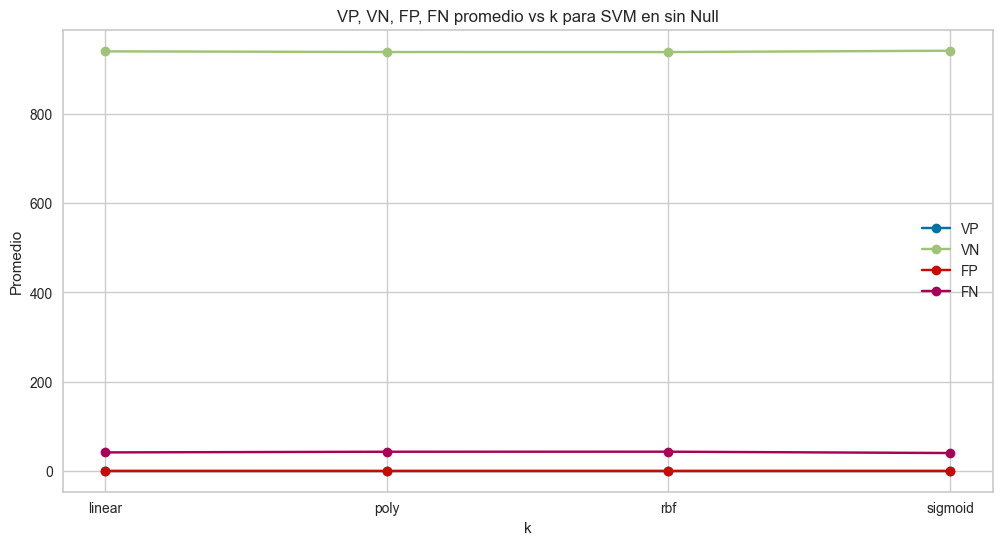

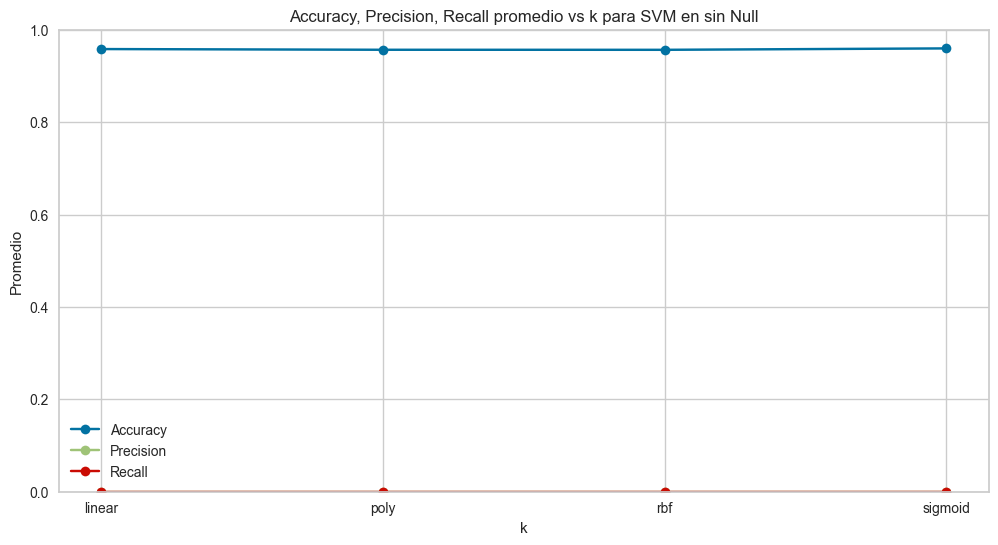

	VP promedio: [np.float64(278.5), np.float64(255.8), np.float64(261.8), np.float64(105.3)]	VN promedio: [np.float64(793.2), np.float64(801.7), np.float64(793.2), np.float64(658.3)]
	FP promedio: [np.float64(138.3), np.float64(128.9), np.float64(149.3), np.float64(285.2)]	FN promedio: [np.float64(148.0), np.float64(171.6), np.float64(153.7), np.float64(309.2)]
	Accuracy promedio: 0.7267673048600882
	Precision promedio: 0.5603548348648368
	Recall promedio: 0.5342315251234347


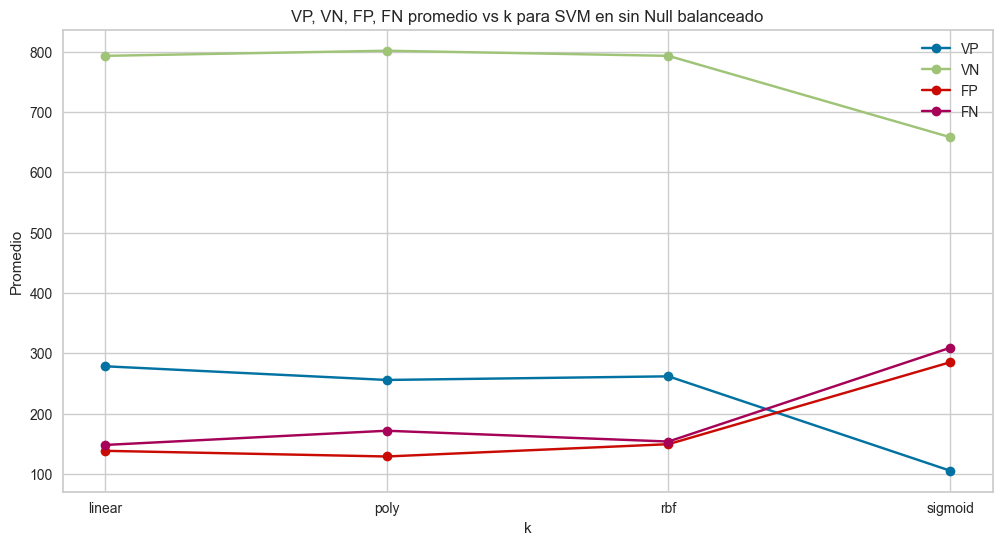

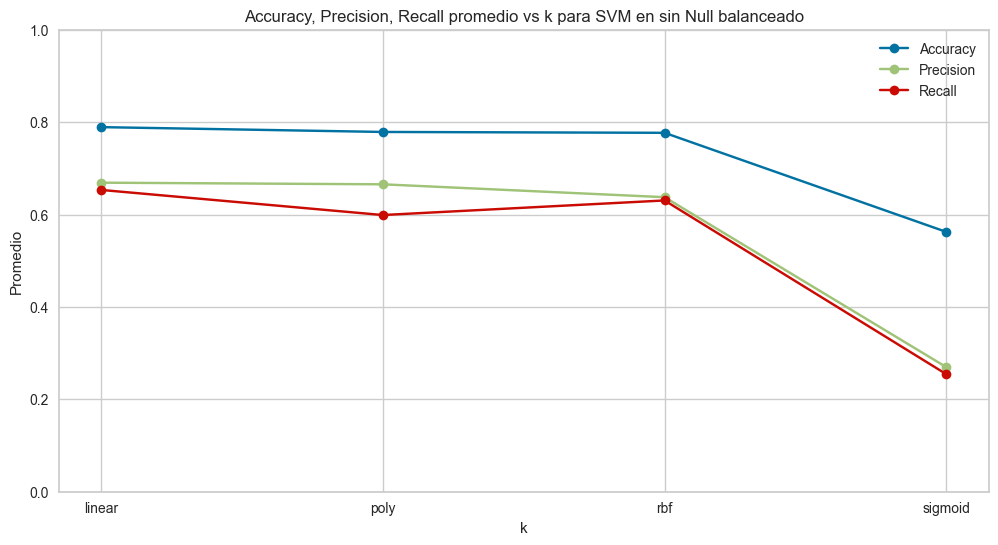

	VP promedio: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.5)]	VN promedio: [np.float64(971.1), np.float64(972.1), np.float64(970.9), np.float64(971.0)]
	FP promedio: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(2.3)]	FN promedio: [np.float64(50.9), np.float64(49.9), np.float64(51.1), np.float64(48.2)]
	Accuracy promedio: 0.9504892367906067
	Precision promedio: 0.004464285714285714
	Recall promedio: 0.0022727272727272726


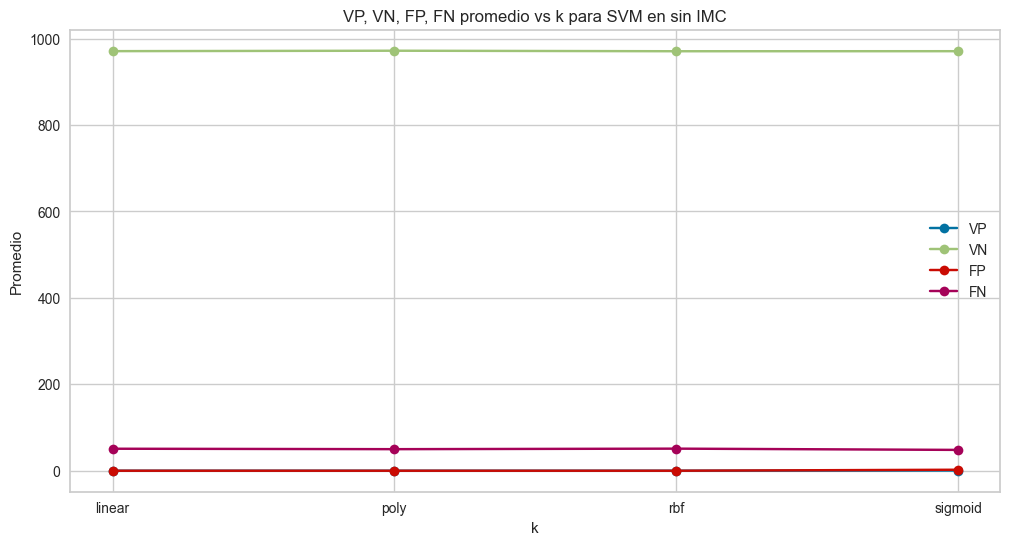

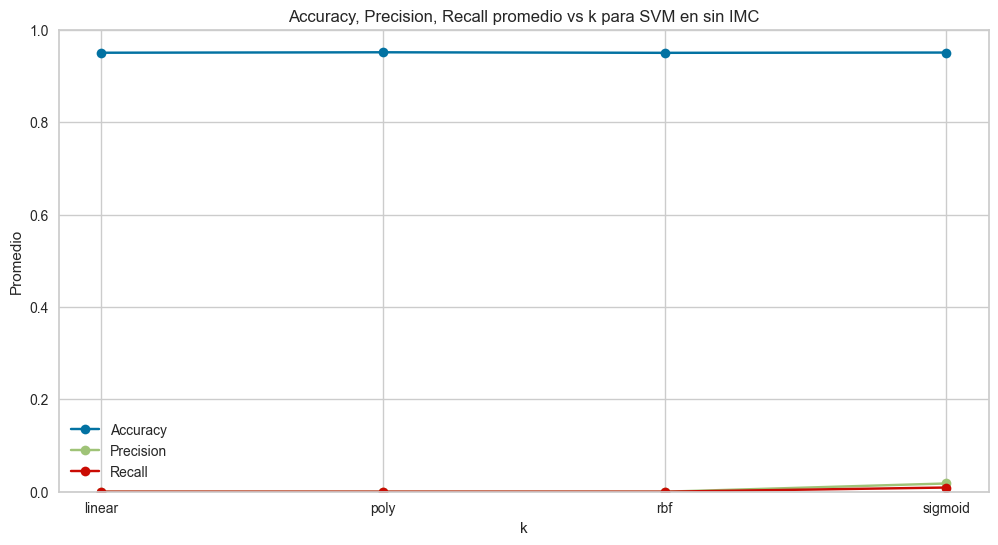

	VP promedio: [np.float64(338.5), np.float64(303.3), np.float64(339.4), np.float64(166.9)]	VN promedio: [np.float64(805.3), np.float64(824.4), np.float64(796.4), np.float64(664.3)]
	FP promedio: [np.float64(172.9), np.float64(153.2), np.float64(176.4), np.float64(313.0)]	FN promedio: [np.float64(154.3), np.float64(190.1), np.float64(158.8), np.float64(326.8)]
	Accuracy promedio: 0.7203433038749152
	Precision promedio: 0.5820683609075976
	Recall promedio: 0.580154491773963


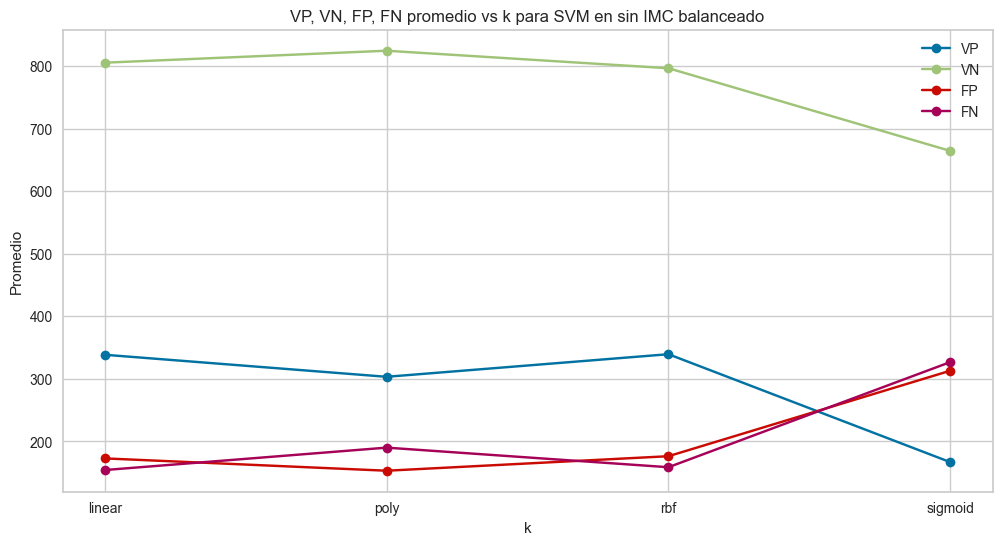

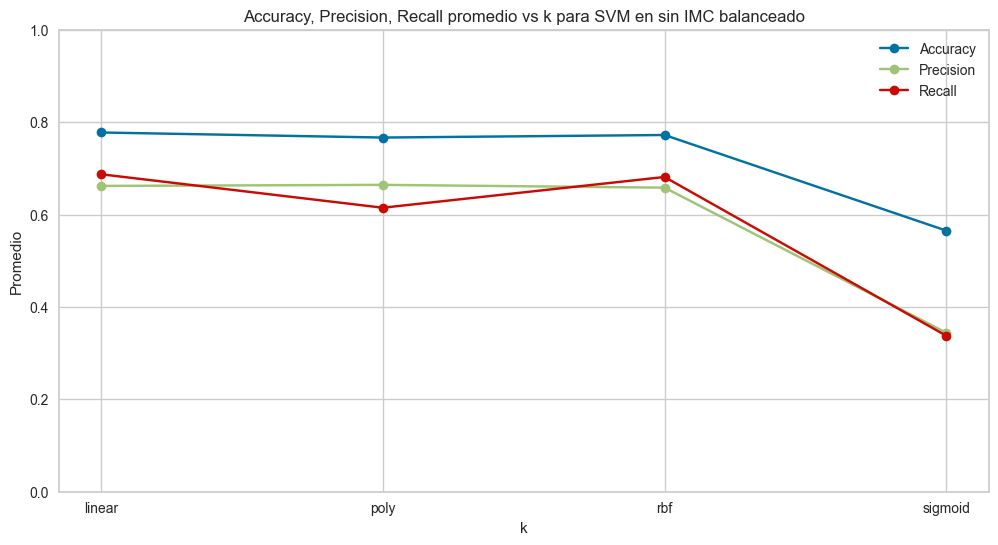

In [13]:
# SVM
prueba_modelos_SVM(dataset, "SVM", "sin Null")
prueba_modelos_SVM(balanced_dataset, "SVM", "sin Null balanceado")
prueba_modelos_SVM2(dataset_no_bmi, "SVM", "sin IMC")
prueba_modelos_SVM2(balanced_dataset2, "SVM", "sin IMC balanceado")